In [ ]:
from autograd.tensor import Tensor as tn
from autograd.dropout import *
from autograd.parameter import Parameter as pr
from autograd.flatten import Flatten as fl
from autograd.module import Module
from autograd.nn import Sequential
from autograd.linear import Linear
from autograd.act import Relu, Sigmoid 
from autograd.loss import CEL
from autograd.optim import GD

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [59]:
import time
import numpy
np.random.seed(0)

data = tn(np.array([[0,0],[0,1],[1,0],[1,1]]),True)
target = tn(np.array([[0],[1],[0],[1]]),True)

w = list()
weights_0_1 = tn(np.random.rand(2,3),True)
weights_1_2 = tn(np.random.rand(3,1),True)
w.append(weights_0_1)
w.append(weights_1_2)



start = time.time()
for i in range(10):
    
    # Predict
    layer_1 = data @ weights_0_1
    layer_2 = layer_1 @ weights_1_2
    # Compare
    diff = (layer_2 - target)
    sqdiff = (diff * diff)
    loss = sqdiff.sum() # mean squared error loss

    # Learn: this is the backpropagation piece
    loss.backward()

    for w_ in w:
        w_.data -= w_.grad.data * 0.1
        w_.zero_grad()
    print(loss)
end = time.time()
print(end - start)

Tensor(2.973981747096818, requires_grad=True)
Tensor(1.1525848858146912, requires_grad=True)
Tensor(0.8092322200712426, requires_grad=True)
Tensor(0.648900955935711, requires_grad=True)
Tensor(0.5302958839700223, requires_grad=True)
Tensor(0.42924981305548227, requires_grad=True)
Tensor(0.3420929727522987, requires_grad=True)
Tensor(0.26729885677431675, requires_grad=True)
Tensor(0.2040379153116074, requires_grad=True)
Tensor(0.15171079130161946, requires_grad=True)
0.010184049606323242


In [51]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


In [60]:
import numpy
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

w = list()
w.append(Tensor(np.array([[0.85794562 ,0.84725174 ,0.6235637 ],
 [0.38438171 ,0.29753461 ,0.05671298]]), autograd=True))
w.append(Tensor(np.array([[0.47766512],
 [0.81216873],
 [0.47997717]]), autograd=True))

start = time.time()

for i in range(10):

    # Predict
    pred = data.mm(w[0]).mm(w[1])
    
    # Compare
    loss = ((pred - target)*(pred - target)).sum(0)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))

    for w_ in w:
        w_.data -= w_.grad.data * 0.1
        w_.grad.data *= 0

    print(loss)
end = time.time()
print(end - start)

[2.97398178]
[1.15258489]
[0.80923222]
[0.64890096]
[0.53029588]
[0.42924981]
[0.34209297]
[0.26729886]
[0.20403792]
[0.15171079]
0.017199277877807617


In [50]:
import numpy
np.random.seed(0)

data = np.array([[0,0],[0,1],[1,0],[1,1]])
target = np.array([[0],[1],[0],[1]])

weights_0_1 = np.array([[0.85794562 ,0.84725174 ,0.6235637 ],
 [0.38438171 ,0.29753461 ,0.05671298]])

weights_1_2 = np.array([[0.47766512],
 [0.81216873],
 [0.47997717]])
print(weights_1_2)

for i in range(10):
    
    # Predict
    layer_1 = data @ weights_0_1
    layer_2 = layer_1 @ weights_1_2

    # Compare
    diff = (layer_2 - target)
    sqdiff = (diff * diff)
    loss = sqdiff.sum(0) # mean squared error loss

    # Learn: this is the backpropagation piece
    layer_1_grad = diff.dot(weights_1_2.transpose())
    weight_1_2_update = layer_1.transpose().dot(diff)
    weight_0_1_update = data.transpose().dot(layer_1_grad)
    
    weights_1_2 -= weight_1_2_update * 0.1
    weights_0_1 -= weight_0_1_update * 0.1
    print(loss[0])

[[0.47766512]
 [0.81216873]
 [0.47997717]]
2.9739817759207106
1.1386077634035665
0.9503752598761414
0.8477935879208961
0.7687994191412023
0.7000083625355942
0.6374749719001984
0.579685958415488
0.5258833043645329
0.4756057918655521


In [64]:
r = tn(np.random.randn(4,3,2,3))
r

Tensor([[[[-0.94035354  0.92959433 -1.06279492]
   [-0.88640627  1.92134696 -0.45978052]]

  [[-1.08903444  0.98411729 -1.15920632]
   [-0.43653709  1.00924453  0.71338957]]

  [[-0.72805772  0.83951646  1.23902098]
   [-1.78480389 -0.79618584 -1.40054127]]]


 [[[-0.18435058 -1.39119312  0.03625974]
   [-0.81440556  0.69737282 -1.73742924]]

  [[ 0.1158557   0.36565145 -0.07392347]
   [-0.49351757  3.10153058  0.85875415]]

  [[-1.15477553  0.94183434 -0.28213514]
   [-0.97565467  0.09818669  0.90548995]]]


 [[[ 1.01874144 -0.11489885  1.74303872]
   [-0.32187919  0.82957109 -0.207318  ]]

  [[ 1.11799861  1.06424968  1.15132983]
   [-0.77245771 -1.29363428  0.67702681]]

  [[ 0.4240552  -0.48567617 -0.05169724]
   [ 0.56705637  1.06783358  0.27159574]]]


 [[[ 0.61930177 -0.058626    1.2565714 ]
   [ 0.2967472   0.39858573 -1.05317438]]

  [[-0.63947627 -0.14852688 -1.57458215]
   [-0.4956882  -0.11757479  0.37312016]]

  [[-0.38602877 -1.23059312 -1.95827161]
   [-0.51796269  0.579

In [67]:
r[...,2]

Tensor([[[-1.06279492 -0.45978052]
  [-1.15920632  0.71338957]
  [ 1.23902098 -1.40054127]]

 [[ 0.03625974 -1.73742924]
  [-0.07392347  0.85875415]
  [-0.28213514  0.90548995]]

 [[ 1.74303872 -0.207318  ]
  [ 1.15132983  0.67702681]
  [-0.05169724  0.27159574]]

 [[ 1.2565714  -1.05317438]
  [-1.57458215  0.37312016]
  [-1.95827161 -1.35373284]]], requires_grad=False)

In [69]:
for i in range(0,100,32):
    print(i)

0
32
64
96


In [40]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        inputs_ = inputs[excerpt]
        inputs_ = inputs_.reshape(inputs_.shape[0], -1).T
        
        targets_ = targets[excerpt]
        targets_ = targets_.reshape(targets_.shape[0], -1).T
        
        yield tn(inputs_), tn(targets_)

In [41]:
from Dataset1 import catnoncat


In [42]:
train_x = catnoncat.train_x() 
test_x = catnoncat.test_img() 

In [43]:


#train_x = fl().forward(train_x)
#test_x = fl().forward(test_x)
#train_x = train_x.data
#test_x = test_x.data

In [44]:
train_y = tn(catnoncat.train_y())
test_y = tn(catnoncat.test_y())

In [48]:
train_x = train_x.reshape(train_x.shape[0], -1).T


In [46]:
train_y = train_y.data.reshape(train_y.data.shape[0], -1).T

In [49]:
X = train_x
Y = train_y
print(Y.shape,X.shape)




(209, 1) (209, 12288)


In [64]:
mod2 = Sequential([
         Linear(50,12288),
            Relu(),
        #Dropout(.9),
         Linear(20,50),
            Relu(),
        #Dropout(.9),
         Linear(10,20),
            Relu(),
        #Dropout(.9),
         Linear(1,10),
            Sigmoid()])

0 2.221715436379601
100 1.8518230298011162
200 1.7914018002493004
300 1.689644361440539
400 1.6266123291652475
500 1.5191921787454636
600 1.4633743939812938
700 1.3467065202549793
800 1.2843724277222521
900 1.2068832745905715
1000 1.1403792942773072
1100 1.1031763508718893
1200 1.0301783842499028
1300 0.9906973379518542
1400 0.9599488195978627
1500 0.896955098834117
1600 0.8431044032803237
1700 0.8223686728629511
1800 0.7740837210545408
1900 0.7373953383519072
2000 0.7121157358972231
2100 0.6770496733791194
2200 0.645676218853944
2300 0.6128527772573465
2400 0.5950146100774534
2500 0.5721997715068396
2600 0.537336608039728
2700 0.5105893586469508
2800 0.502366427829644
2900 0.48792525762410655
3000 0.4742774471603093
3100 0.4633819990459521
3200 0.4264421326516883
3300 0.4151781195951647
3400 0.3930785102576523
3500 0.3993535531297261
3600 0.38049525055702216
3700 0.3571372202209674
3800 0.3550808084136797
3900 0.34814293900740095
4000 0.32174032621091586
4100 0.3212709732064312
4200 0

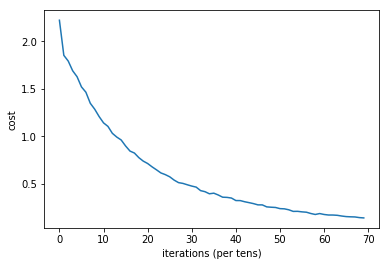

In [65]:
optimizer = GD(lr=.0075)


costs = []


for epoch in range(7000):

    epoch_loss = 0.0
    
    for batch in iterate_minibatches(X, Y, 64, shuffle=True):
        x_batch, y_batch = batch
        train_x, train_y = x_batch, y_batch
        for l in mod2.layers:
            l.zero_grad()

        out = mod2.forward(train_x)
        cout = CEL(out,train_y)
        loss = cout.sum()

        loss.backward()
        epoch_loss += loss.data

        for l in mod2.layers:
            optimizer.step(l)


    if epoch % 100 == 0:
        print(epoch, epoch_loss)
    if epoch % 100 == 0:
        costs.append(epoch_loss)


# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.show()

In [66]:
test_x = catnoncat.test_img() 
test_x = fl().forward(test_x)
test_y = tn(catnoncat.test_y())


data shape: (12288, 50)


In [67]:
mod2.predict(test_x,test_y)

Accuracy: 0.76


In [180]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


In [181]:
from Dataset1 import catnoncat


In [182]:
train_x = catnoncat.train_x() 
test_x = catnoncat.test_img()

In [183]:
train_y =catnoncat.train_y()
test_y =catnoncat.test_y()

In [184]:
x_data = train_x.reshape(-1,train_x.shape[0]).T

labels = train_y.reshape(train_y.shape[0], -1).T

print(labels.shape,x_data.shape)

(209, 1) (209, 12288)


In [185]:
x_data1 = test_x.reshape(-1,test_x.shape[0]).T

labels1 = test_y.reshape(test_y.shape[0], -1).T

print(labels1.shape,x_data1.shape)

(50, 1) (50, 12288)


In [186]:
train_data = []
for i in range(len(x_data)):
    train_data.append([x_data[i], labels[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
i1, l1 = next(iter(trainloader))
print(l1.shape)

torch.Size([100, 1])


In [187]:
test_data = []
for i in range(len(x_data1)):
    test_data.append([x_data1[i], labels1[i]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=100)
i1, l1 = next(iter(test_loader))
print(l1.shape)

torch.Size([50, 1])


In [203]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes)
        self.linear2 = nn.Linear(num_classes,1)
        self.m = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        sout = self.m(out)
        return sout

In [208]:
input_size = 12288
num_classes = 1
num_epochs = 7000
batch_size = 100
learning_rate = 0.01

In [209]:
model = LogisticRegression(input_size, num_classes)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.float())
        labels = Variable(labels.float())
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs.shape,labels.shape)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.float().size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images: 1700 %
